In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold, chi2
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder, LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
import time

## Create the evaluation function

In [2]:
# Function for feature selection version 1
def feature_selection(X, Y):
    f, p = f_classif(X, Y)
    corr_df = pd.DataFrame({'features': X.columns, 'f_val': f, 'p_val': p})
    # using the 3 level significance test 
    # (***: p_val < 0.001, **: p_val < 0.01, *: p_val < 0.05)
    # we will select the features with p_val < 0.05
    p_tr = 0.001
    relevant_features = corr_df.loc[corr_df['p_val'] < p_tr, "features"].tolist()
    # print(f"There are {len(relevant_features)} relevant features and they are: {relevant_features}")
    
    return relevant_features

I created a feature selection function that includes different selection methods:

In [3]:
# Function for feature selection version 2
def select_features(X, y, method, corr_threshold=0.5):
    
    if method is None:
        return X.columns
        
    # Feature selection using chi-squared
    elif method == 'p-value':
        # Remove constant features
        X = X.loc[:, X.apply(pd.Series.nunique) != 1]
        p_values = []
        for feature in X.columns:
            f, p = chi2(X[[feature]], y)
            p_values.append(p)

        p_values = np.array(p_values).reshape(-1)
        p_values = pd.Series(p_values, index=X.columns).sort_values()
        selected_features = p_values[p_values < 0.05].index
    
    # Feature selection using VarianceThreshold
    elif method == 'variance':
        X = X.loc[:, X.apply(pd.Series.nunique) != 1]
        var_thr = VarianceThreshold(threshold=0.25)
        var_thr.fit(X)
        selected_features = X.columns[var_thr.get_support()]  
    
    # Feature selection using Pearson correlation
    elif method == 'correlation':
        X = X.loc[:, X.apply(pd.Series.nunique) != 1]
        corr = X.corr()
        col_corr = set()

        corr_matrix = np.abs(corr.values)

        n = corr_matrix.shape[0]

        for i in range(n):
            for j in range(i):
                if corr_matrix[i, j] > corr_threshold:
                    colname = X.columns[i]
                    col_corr.add(colname)

        selected_features = [col for col in X.columns if col not in col_corr]

    # More methods to be added 
                
    return selected_features

I created a scaling function which includes different scaling methods:

In [4]:
# Function for scaling the data
def scale(X_train, X_test, method):
    
    if method is None:
        return X_train, X_test

    # Scaling using StandardScaler 
    elif method == 'standard':
        scaler = StandardScaler().fit(X_train)

    # Scaling using MinMaxScaler
    elif method == 'minmax':
        scaler = MinMaxScaler().fit(X_train)

    # Scaling using RobustScaler
    elif method == 'robust':
        scaler = RobustScaler().fit(X_train)

    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
                
    return X_train_scaled, X_test_scaled

Time measurements have been added

In [5]:
def evaluate_model(X, Y, feature_selection, scaling, classifier, splitting, folds=5):
    if splitting == "cv":
        kf = KFold(n_splits=folds, shuffle=True, random_state=18)
        metric_results = {}
        #do the KFold cross validation
        for train_index, test_index in kf.split(X,Y):
            # split the data into train and test for this fold
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]   
            
            # preprocess the data
            # feature selection
            preprocess_start_time = time.time()
            rel_features = select_features(X_train, y_train, feature_selection)
            n_features_orig = X_train.shape[1]
            n_features = len(rel_features)
            # scaling the data
            X_train_preprocessed, X_test_preprocessed = scale(X_train[rel_features], X_test[rel_features], scaling)
            preprocess_end_time = time.time()
            preprocess_time = preprocess_end_time - preprocess_start_time

            

            """ if preprocess == "none":
                X_train_preprocessed = X_train
                X_test_preprocessed = X_test
            elif preprocess == "featureselection":
                # sig_selector = VarianceThreshold(threshold=0.4)
                # X_train_preprocessed = sig_selector.fit_transform(X_train)
                # X_test_preprocessed = sig_selector.transform(X_test)
                rel_features = select_features(X_train, y_train, )
                X_train_preprocessed = X_train[rel_features]
                X_test_preprocessed = X_test[rel_features]
            else:
                scaler = StandardScaler()
                X_train_preprocessed = scaler.fit_transform(X_train)
                X_test_preprocessed = scaler.transform(X_test) """
                
            # train and evaluate the model
            clf = classifier
            train_start_time = time.time()
            clf.fit(X_train_preprocessed, y_train)
            train_end_time = time.time()
            training_time = train_end_time - train_start_time
            
            pred_start_time = time.time()
            Y_pred_fold = clf.predict(X_test_preprocessed)
            pred_end_time = time.time()
            prediction_time = pred_end_time - pred_start_time
                
            # calculate the accuracy, precision, recall and f1 score per fold
            accuracy = metrics.accuracy_score(y_test, Y_pred_fold)
            precision = metrics.precision_score(y_test, Y_pred_fold, average='weighted')
            recall = metrics.recall_score(y_test, Y_pred_fold, average='weighted')
            f1 = metrics.f1_score(y_test, Y_pred_fold, average='weighted')

            # add the scores to the dict
            metric_results.setdefault('accuracy', []).append(accuracy)
            metric_results.setdefault('precision', []).append(precision)
            metric_results.setdefault('recall', []).append(recall)
            metric_results.setdefault('f1', []).append(f1)
            metric_results.setdefault('training_time', []).append(training_time)
            metric_results.setdefault('prediction_time', []).append(prediction_time)
            metric_results.setdefault('preprocess_time', []).append(preprocess_time)
            
            
        # Calculate the mean of the metrics over all folds
        accuracy_mean = np.mean(metric_results['accuracy'])
        precision_mean = np.mean(metric_results['precision'])
        recall_mean = np.mean(metric_results['recall'])
        f1_mean = np.mean(metric_results['f1'])
        training_time_mean = np.mean(metric_results['training_time'])
        prediction_time_mean = np.mean(metric_results['prediction_time'])
        preprocess_time_mean = np.mean(metric_results['preprocess_time'])
        
        # Calculate the standard deviation of f1
        f1_std = np.std(metric_results['f1'])

        return {'classifier': classifier.__class__.__name__, 'splitting': splitting, 'feature_selection': feature_selection, 'scaling': scaling, 'n_features_orig': n_features_orig, 'n_features': n_features, 'accuracy': accuracy_mean, 'precision': precision_mean, 'recall': recall_mean, 'f1': f1_mean, 'f1_std': f1_std, 'preprocess_time': preprocess_time_mean,'training_time': training_time_mean, 'prediction_time': prediction_time_mean}

    elif splitting == "holdout":
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=18)
        
        # preprocess the data
        # feature selection
        preprocess_start_time = time.time()
        rel_features = select_features(X_train, y_train, feature_selection)
        n_features_orig = X_train.shape[1]
        n_features = len(rel_features)
        # scaling the data
        X_train_preprocessed, X_test_preprocessed = scale(X_train[rel_features], X_test[rel_features], scaling)
        preprocess_end_time = time.time()
        preprocess_time = preprocess_end_time - preprocess_start_time


        

        # train and evaluate the model
        clf = classifier
        train_start_time = time.time()
        clf.fit(X_train_preprocessed, y_train)
        train_end_time = time.time()
        training_time = train_end_time - train_start_time
        
        pred_start_time = time.time()
        Y_pred = clf.predict(X_test_preprocessed)
        pred_end_time = time.time()
        prediction_time = pred_end_time - pred_start_time

        # calculate the accuracy, precision, recall and f1 score per fold
        accuracy = metrics.accuracy_score(y_test, Y_pred)
        precision = metrics.precision_score(y_test, Y_pred, average='weighted')
        recall = metrics.recall_score(y_test, Y_pred, average='weighted')
        f1 = metrics.f1_score(y_test, Y_pred, average='weighted')

        return {'classifier': classifier.__class__.__name__, 'splitting': splitting, 'feature_selection': feature_selection, 'scaling': scaling, 'n_features_orig': n_features_orig, 'n_features': n_features, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'preprocess_time': preprocess_time,'training_time': training_time, 'prediction_time': prediction_time}
    

### Smote function for balancing class column

For those datasets that have an imbalanced response variable the smote method can be implimented to compensate for the class imbalance in the data

In [6]:
def apply_smote(df, target_column, k_neighbors=4, random_state=321):

    X = df.drop(target_column, axis=1)
    y = df[target_column]

    sm = SMOTE(random_state=random_state, k_neighbors=k_neighbors)
    X_resampled, y_resampled = sm.fit_resample(X, y)

    return X_resampled, y_resampled

## Load the data



### Congressional voting
An iterativ imputation has been already done on the data.

In [7]:
test_df = pd.read_csv("./preprocessed-datasets/CongressionVoting_prepro.csv")
test_df.set_index('ID', inplace=True)
test_df_X = test_df.drop(columns=["class"])
test_df_Y = test_df["class"]

## Evaluation

The **evaluate_model** function takes:
* the input feature (*X*),
* the dependent variable (*Y*)
* the preprocessing method as a string:
    * the so far implemented possible options can be found in the *preprocess_options* list. Here *else* is implemented as the *StandardScaler()*, however it could be combined with additional feature selection to achieve a better result.
* classifier as a function:
    * so far the only tried one is *SVC(C=3, kernel='sigmoid')*
* folds to define the number of  folds. The default value is 5.

In [8]:
#preprocess_options = ["none", "featureselection", "else"]

The changed evaluate_model function is the following:
* takes the input feature and the dependent variable
* splits the data into train and test set
* preprocesses the data
    * feature selection
    * scaling 
* trains the classifier on the train set

In [9]:
evaluate_model(test_df_X, test_df_Y, "p-value", "robust", SVC(C=3, kernel='sigmoid'), splitting="cv")

{'classifier': 'SVC',
 'splitting': 'cv',
 'feature_selection': 'p-value',
 'scaling': 'robust',
 'n_features_orig': 16,
 'n_features': 13,
 'accuracy': 0.9447145877378436,
 'precision': 0.9458858894825214,
 'recall': 0.9447145877378436,
 'f1': 0.9446694623832087,
 'f1_std': 0.023332176291890664,
 'preprocess_time': 0.06401348114013672,
 'training_time': 0.00048012733459472655,
 'prediction_time': 0.0}

## Experimeting a bit

Loading the datasets

In [10]:
bank_marketing = pd.read_csv("./preprocessed-datasets/bank_marketing_prepro.csv")
bank_marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     41188 non-null  int64  
 1   age                            41188 non-null  float64
 2   default                        41188 non-null  float64
 3   housing                        41188 non-null  float64
 4   loan                           41188 non-null  float64
 5   campaign                       41188 non-null  float64
 6   pdays                          41188 non-null  float64
 7   previous                       41188 non-null  float64
 8   emp.var.rate                   41188 non-null  float64
 9   cons.price.idx                 41188 non-null  float64
 10  cons.conf.idx                  41188 non-null  float64
 11  euribor3m                      41188 non-null  float64
 12  nr.employed                    41188 non-null 

In [11]:
wine_quality = pd.read_csv("./preprocessed-datasets/wine_quality_prepro.csv")
wine_quality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            6497 non-null   int64  
 1   fixed acidity         6497 non-null   float64
 2   volatile acidity      6497 non-null   float64
 3   citric acid           6497 non-null   float64
 4   residual sugar        6497 non-null   float64
 5   chlorides             6497 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6497 non-null   float64
 10  sulphates             6497 non-null   float64
 11  alcohol               6497 non-null   float64
 12  class                 6497 non-null   int64  
 13  wine_type             6497 non-null   int64  
dtypes: float64(11), int64(3)
memory usage: 710.7 KB


In [12]:
congression_voting = pd.read_csv("./preprocessed-datasets/CongressionVoting_prepro.csv")
congression_voting.set_index('ID', inplace=True)
congression_voting.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217 entries, 140 to 324
Data columns (total 17 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   handicapped-infants                     217 non-null    float64
 1   water-project-cost-sharing              217 non-null    float64
 2   adoption-of-the-budget-resolution       217 non-null    float64
 3   physician-fee-freeze                    217 non-null    float64
 4   el-salvador-aid                         217 non-null    float64
 5   religious-groups-in-schools             217 non-null    float64
 6   anti-satellite-test-ban                 217 non-null    float64
 7   aid-to-nicaraguan-contras               217 non-null    float64
 8   mx-missile                              217 non-null    float64
 9   immigration                             217 non-null    float64
 10  synfuels-crporation-cutback             217 non-null    floa

In [13]:
reviews = pd.read_csv("./preprocessed-datasets/Review_prepro.csv")
reviews.set_index('ID', inplace=True)
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 750 entries, 0 to 749
Columns: 10001 entries, V1 to class
dtypes: int64(10000), object(1)
memory usage: 57.2+ MB


In [19]:
datasets = {
    'wine_quality': wine_quality,
    #'reviews': reviews,
    'congression_voting': congression_voting,
    'bank_marketing': bank_marketing
}

feature_selection_methods = ['p-value', None] # , 'variance' , 'correlation']
scaling_methods = [None, 'standard'] #, 'robust', 'minmax']
classifiers = [LinearSVC(), DecisionTreeClassifier(),RandomForestClassifier(), SVC(C=3, kernel='sigmoid')] #, GaussianNB()]
splitting_methods = ['holdout', 'cv']

results = []

for dataset_name, dataset in datasets.items():
    for feature_selection_method in feature_selection_methods:
        for scaling_method in scaling_methods:
            for classifier in classifiers:
                for splitting_method in splitting_methods: # ,'cv']:
                    if dataset_name == 'wine_quality' or dataset_name == 'bank_marketing':
                        target_column = 'class'
                        X,Y = apply_smote(dataset,target_column)
                    else:
                        X = dataset.drop(columns=["class"])
                        Y = dataset["class"]
                    start_time = time.time()
                    evaluation_result = evaluate_model(X, Y, feature_selection_method, scaling_method, classifier, splitting_method)
                    end_time = time.time()
                    time_taken = end_time - start_time
                    print(f"Time taken for {dataset_name}, {feature_selection_method}, {scaling_method}, {classifier.__class__.__name__}, {splitting_method}: {time_taken} seconds")
                    results.append({'dataset': dataset_name, 'result': evaluation_result})



c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Time taken for wine_quality, p-value, None, LinearSVC, holdout: 11.002210855484009 seconds


c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\s

Time taken for wine_quality, p-value, None, LinearSVC, cv: 91.04194211959839 seconds
Time taken for wine_quality, p-value, None, DecisionTreeClassifier, holdout: 0.6861841678619385 seconds
Time taken for wine_quality, p-value, None, DecisionTreeClassifier, cv: 3.5447843074798584 seconds
Time taken for wine_quality, p-value, None, RandomForestClassifier, holdout: 8.763733625411987 seconds
Time taken for wine_quality, p-value, None, RandomForestClassifier, cv: 46.717021226882935 seconds


c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Time taken for wine_quality, p-value, None, SVC, holdout: 36.224743604660034 seconds


c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedM

Time taken for wine_quality, p-value, None, SVC, cv: 183.79859733581543 seconds


c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Time taken for wine_quality, p-value, standard, LinearSVC, holdout: 10.881654024124146 seconds


c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Time taken for wine_quality, p-value, standard, LinearSVC, cv: 63.30300736427307 seconds
Time taken for wine_quality, p-value, standard, DecisionTreeClassifier, holdout: 0.664170503616333 seconds
Time taken for wine_quality, p-value, standard, DecisionTreeClassifier, cv: 3.468334197998047 seconds
Time taken for wine_quality, p-value, standard, RandomForestClassifier, holdout: 8.125564575195312 seconds
Time taken for wine_quality, p-value, standard, RandomForestClassifier, cv: 28.18683123588562 seconds
Time taken for wine_quality, p-value, standard, SVC, holdout: 7.127349615097046 seconds
Time taken for wine_quality, p-value, standard, SVC, cv: 36.76977562904358 seconds


c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Time taken for wine_quality, None, None, LinearSVC, holdout: 5.157526016235352 seconds


c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\s

Time taken for wine_quality, None, None, LinearSVC, cv: 30.18687891960144 seconds
Time taken for wine_quality, None, None, DecisionTreeClassifier, holdout: 0.24011468887329102 seconds
Time taken for wine_quality, None, None, DecisionTreeClassifier, cv: 1.1023366451263428 seconds
Time taken for wine_quality, None, None, RandomForestClassifier, holdout: 2.911257266998291 seconds
Time taken for wine_quality, None, None, RandomForestClassifier, cv: 16.339695930480957 seconds


c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Time taken for wine_quality, None, None, SVC, holdout: 11.720835447311401 seconds


c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedM

Time taken for wine_quality, None, None, SVC, cv: 62.794262409210205 seconds


c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Time taken for wine_quality, None, standard, LinearSVC, holdout: 3.8198678493499756 seconds


c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Time taken for wine_quality, None, standard, LinearSVC, cv: 22.29910397529602 seconds
Time taken for wine_quality, None, standard, DecisionTreeClassifier, holdout: 0.22029471397399902 seconds
Time taken for wine_quality, None, standard, DecisionTreeClassifier, cv: 1.117704153060913 seconds
Time taken for wine_quality, None, standard, RandomForestClassifier, holdout: 2.9499614238739014 seconds
Time taken for wine_quality, None, standard, RandomForestClassifier, cv: 16.108306646347046 seconds
Time taken for wine_quality, None, standard, SVC, holdout: 6.888356685638428 seconds
Time taken for wine_quality, None, standard, SVC, cv: 37.05074405670166 seconds
Time taken for congression_voting, p-value, None, LinearSVC, holdout: 0.0339658260345459 seconds
Time taken for congression_voting, p-value, None, LinearSVC, cv: 0.1786494255065918 seconds
Time taken for congression_voting, p-value, None, DecisionTreeClassifier, holdout: 0.03945779800415039 seconds
Time taken for congression_voting, p-va

c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Time taken for bank_marketing, p-value, None, LinearSVC, holdout: 7.362521409988403 seconds


c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\z

Time taken for bank_marketing, p-value, None, LinearSVC, cv: 40.34942150115967 seconds
Time taken for bank_marketing, p-value, None, DecisionTreeClassifier, holdout: 0.7385656833648682 seconds
Time taken for bank_marketing, p-value, None, DecisionTreeClassifier, cv: 3.7203011512756348 seconds
Time taken for bank_marketing, p-value, None, RandomForestClassifier, holdout: 5.348848819732666 seconds
Time taken for bank_marketing, p-value, None, RandomForestClassifier, cv: 27.95101308822632 seconds
Time taken for bank_marketing, p-value, None, SVC, holdout: 156.78397178649902 seconds
Time taken for bank_marketing, p-value, None, SVC, cv: 407.6827471256256 seconds


c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Time taken for bank_marketing, p-value, standard, LinearSVC, holdout: 8.959404945373535 seconds


c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Time taken for bank_marketing, p-value, standard, LinearSVC, cv: 52.30731391906738 seconds
Time taken for bank_marketing, p-value, standard, DecisionTreeClassifier, holdout: 0.7677788734436035 seconds
Time taken for bank_marketing, p-value, standard, DecisionTreeClassifier, cv: 3.7997798919677734 seconds
Time taken for bank_marketing, p-value, standard, RandomForestClassifier, holdout: 5.198429107666016 seconds
Time taken for bank_marketing, p-value, standard, RandomForestClassifier, cv: 28.648070573806763 seconds
Time taken for bank_marketing, p-value, standard, SVC, holdout: 222.89551758766174 seconds
Time taken for bank_marketing, p-value, standard, SVC, cv: 1134.2525215148926 seconds


c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Time taken for bank_marketing, None, None, LinearSVC, holdout: 6.255280256271362 seconds


c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\z

Time taken for bank_marketing, None, None, LinearSVC, cv: 40.310142040252686 seconds
Time taken for bank_marketing, None, None, DecisionTreeClassifier, holdout: 0.3856945037841797 seconds
Time taken for bank_marketing, None, None, DecisionTreeClassifier, cv: 1.8612432479858398 seconds
Time taken for bank_marketing, None, None, RandomForestClassifier, holdout: 4.698254346847534 seconds
Time taken for bank_marketing, None, None, RandomForestClassifier, cv: 24.83307695388794 seconds
Time taken for bank_marketing, None, None, SVC, holdout: 152.1526210308075 seconds
Time taken for bank_marketing, None, None, SVC, cv: 408.2940664291382 seconds


c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Time taken for bank_marketing, None, standard, LinearSVC, holdout: 10.854837656021118 seconds


c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zsomb\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Time taken for bank_marketing, None, standard, LinearSVC, cv: 59.89737510681152 seconds
Time taken for bank_marketing, None, standard, DecisionTreeClassifier, holdout: 0.4243602752685547 seconds
Time taken for bank_marketing, None, standard, DecisionTreeClassifier, cv: 2.135155200958252 seconds
Time taken for bank_marketing, None, standard, RandomForestClassifier, holdout: 5.0780298709869385 seconds
Time taken for bank_marketing, None, standard, RandomForestClassifier, cv: 26.42084574699402 seconds
Time taken for bank_marketing, None, standard, SVC, holdout: 217.98662304878235 seconds
Time taken for bank_marketing, None, standard, SVC, cv: 2808.5688996315002 seconds


In [20]:
df = pd.DataFrame(results)
results_df = pd.json_normalize(df['result'])
results_df.insert(0, 'dataset', df['dataset'])
results_df.to_csv('./data/results_wo_reviews.csv', index=False)
results_df

,dataset,classifier,splitting,feature_selection,scaling,n_features_orig,n_features,accuracy,precision,recall,f1,preprocess_time,training_time,prediction_time,f1_std
0,wine_quality,LinearSVC,holdout,p-value,None,13,12,0.151948,0.199730,0.151948,0.129240,0.109783,10.847568,0.009605,NaN
1,wine_quality,LinearSVC,cv,p-value,None,13,12,0.181846,0.274092,0.181846,0.107007,0.165360,18.017434,0.005404,0.011428
2,wine_quality,DecisionTreeClassifier,holdout,p-value,None,13,12,0.781733,0.778158,0.781733,0.779631,0.182003,0.460149,0.010132,NaN
3,wine_quality,DecisionTreeClassifier,cv,p-value,None,13,12,0.802791,0.799491,0.802791,0.800747,0.138892,0.545366,0.004202,0.008543
4,wine_quality,RandomForestClassifier,holdout,p-value,None,13,12,0.863499,0.859042,0.863499,0.860306,0.223293,8.237601,0.277826,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,bank_marketing,DecisionTreeClassifier,cv,None,standard,34,34,0.908340,0.908406,0.908340,0.908336,0.049288,0.350233,0.001120,0.001183
92,bank_marketing,RandomForestClassifier,holdout,None,standard,34,34,0.935702,0.936984,0.935702,0.935659,0.049223,4.620787,0.341235,NaN
93,bank_marketing,RandomForestClassifier,cv,None,standard,34,34,0.938998,0.940016,0.938998,0.938963,0.045083,5.005033,0.203964,0.000683
94,bank_marketing,SVC,holdout,None,standard,34,34,0.586256,0.586253,0.586256,0.586253,0.039375,200.235632,17.643829,NaN


In [34]:
# in case the pipeline is not run separately
results_df = pd.read_csv('./data/results_wo_reviews.csv')
results_df.fillna("no_preprocessing", inplace=True)

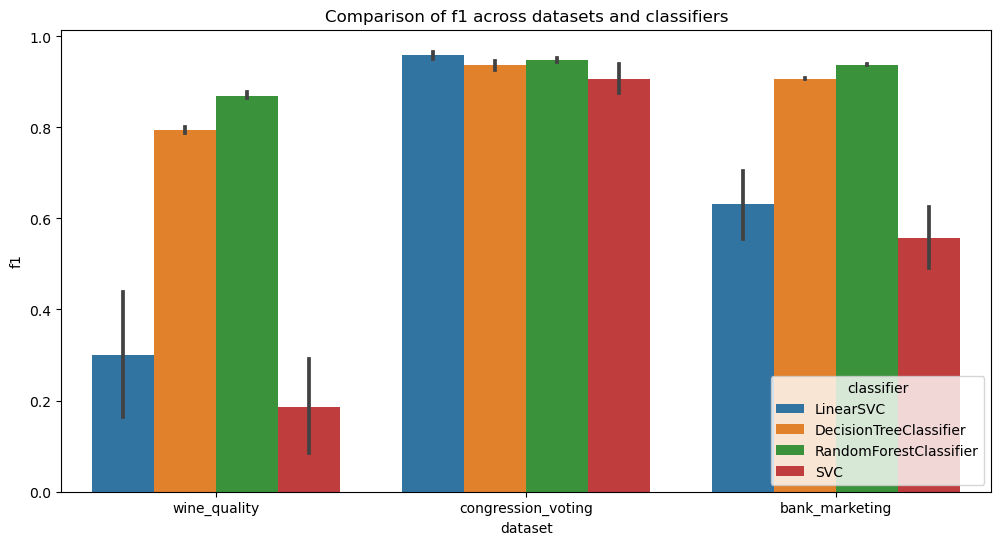

In [15]:
plt.figure(figsize=(12, 6))
sns.barplot(x='dataset', y='f1', hue='classifier', data=results_df)
plt.title('Comparison of f1 across datasets and classifiers')
plt.show()

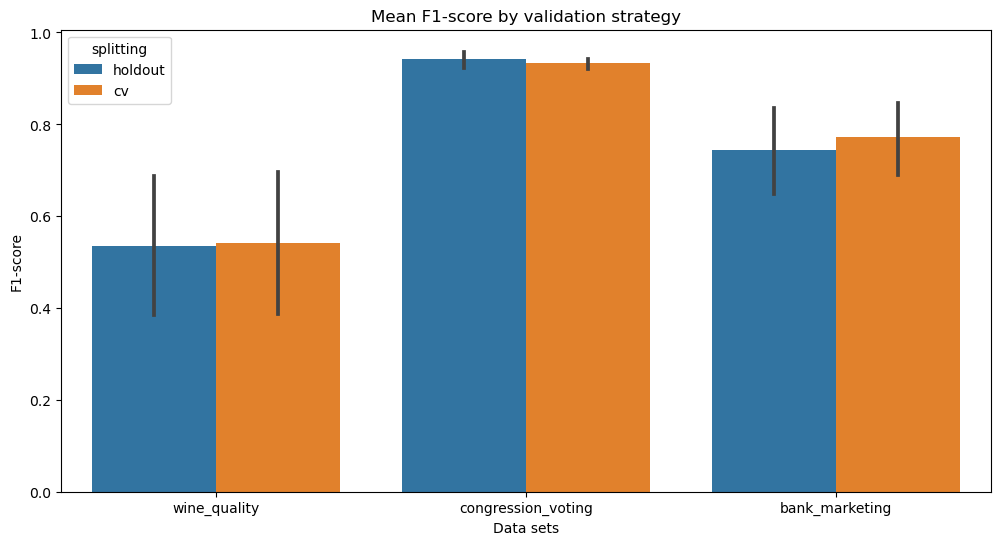

In [16]:
#plot f1-score across datasets for each classifier, cv vs holdout
plt.figure(figsize=(12, 6))
sns.barplot(x='dataset', y='f1', hue='splitting', data=results_df)
plt.title('Mean F1-score by validation strategy')
plt.ylabel('F1-score')
plt.xlabel('Data sets')
plt.show()

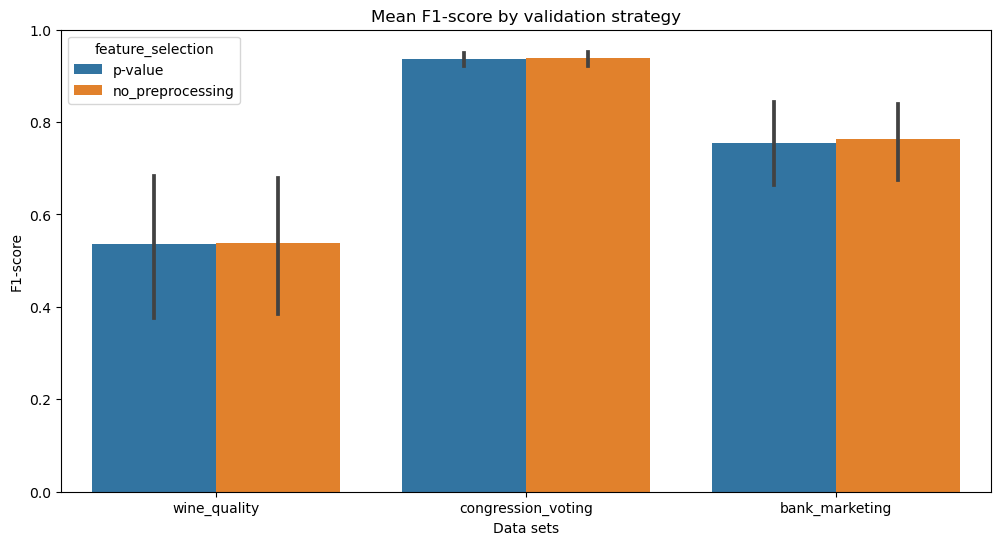

In [35]:
# data.groupby(['dataset', 'Spliting'])['Mean F1-score'].mean().unstack().plot(kind='bar', figsize=(10,5))
plt.figure(figsize=(12, 6))
sns.barplot(x='dataset', y='f1', hue='feature_selection', data=results_df)
plt.title('Mean F1-score by validation strategy')
plt.ylabel('F1-score')
plt.xlabel('Data sets')
plt.show()

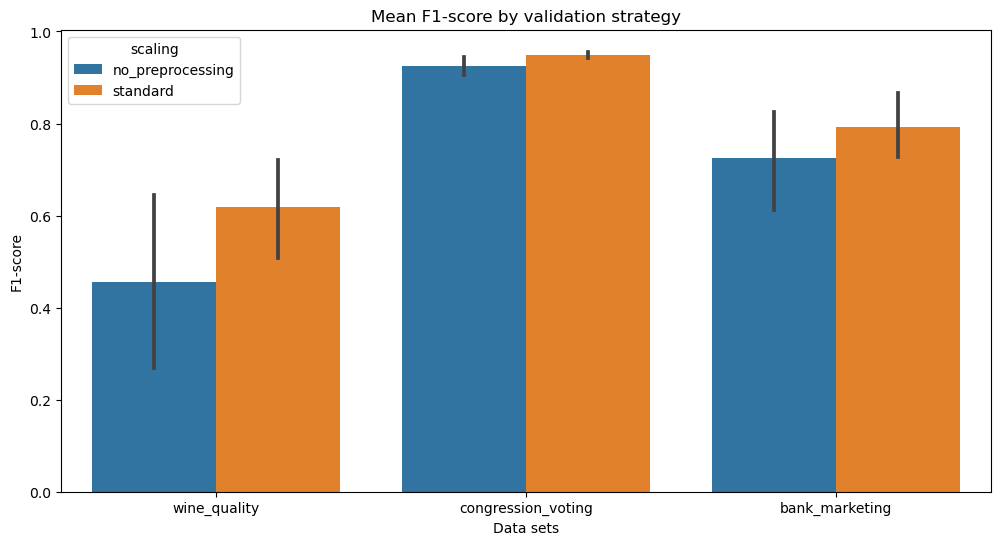

In [36]:
plt.figure(figsize=(12, 6))
sns.barplot(x='dataset', y='f1', hue='scaling', data=results_df)
plt.title('Mean F1-score by validation strategy')
plt.ylabel('F1-score')
plt.xlabel('Data sets')
plt.show()

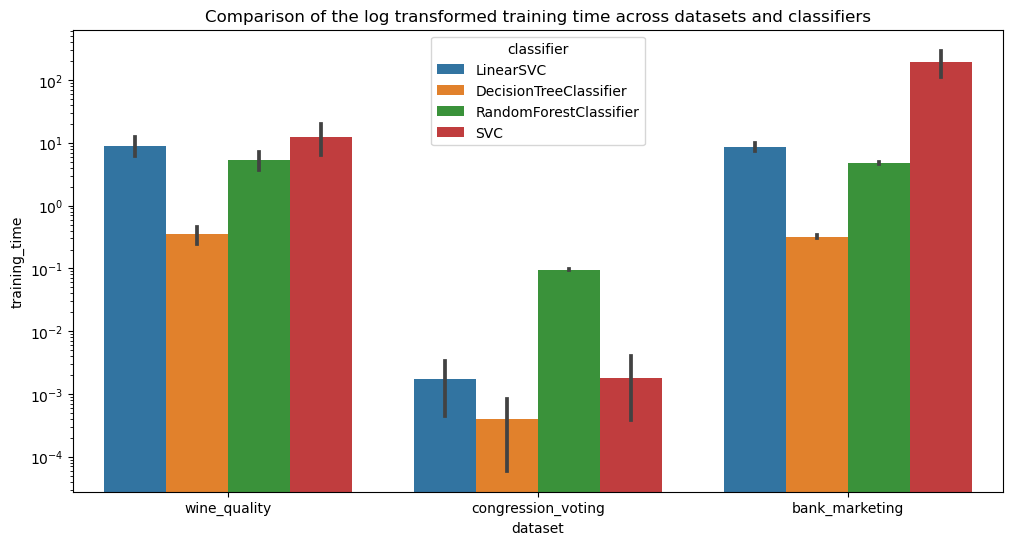

In [21]:
plt.figure(figsize=(12, 6))
sns.barplot(x='dataset', y='training_time', hue='classifier', data=results_df, log=True)
plt.title('Comparison of the log transformed training time across datasets and classifiers')
plt.show()